# DC resistivity forward modelling to determine detectability of fault offset: A case study of two sites in the Fraser Canyon: Phase 1
_Raul Benjamin Mendoza_

In this notebook, I aim to use _discretize_ and _SimPEG_ to replicate the results I attained from inverting field data using EarthImager:
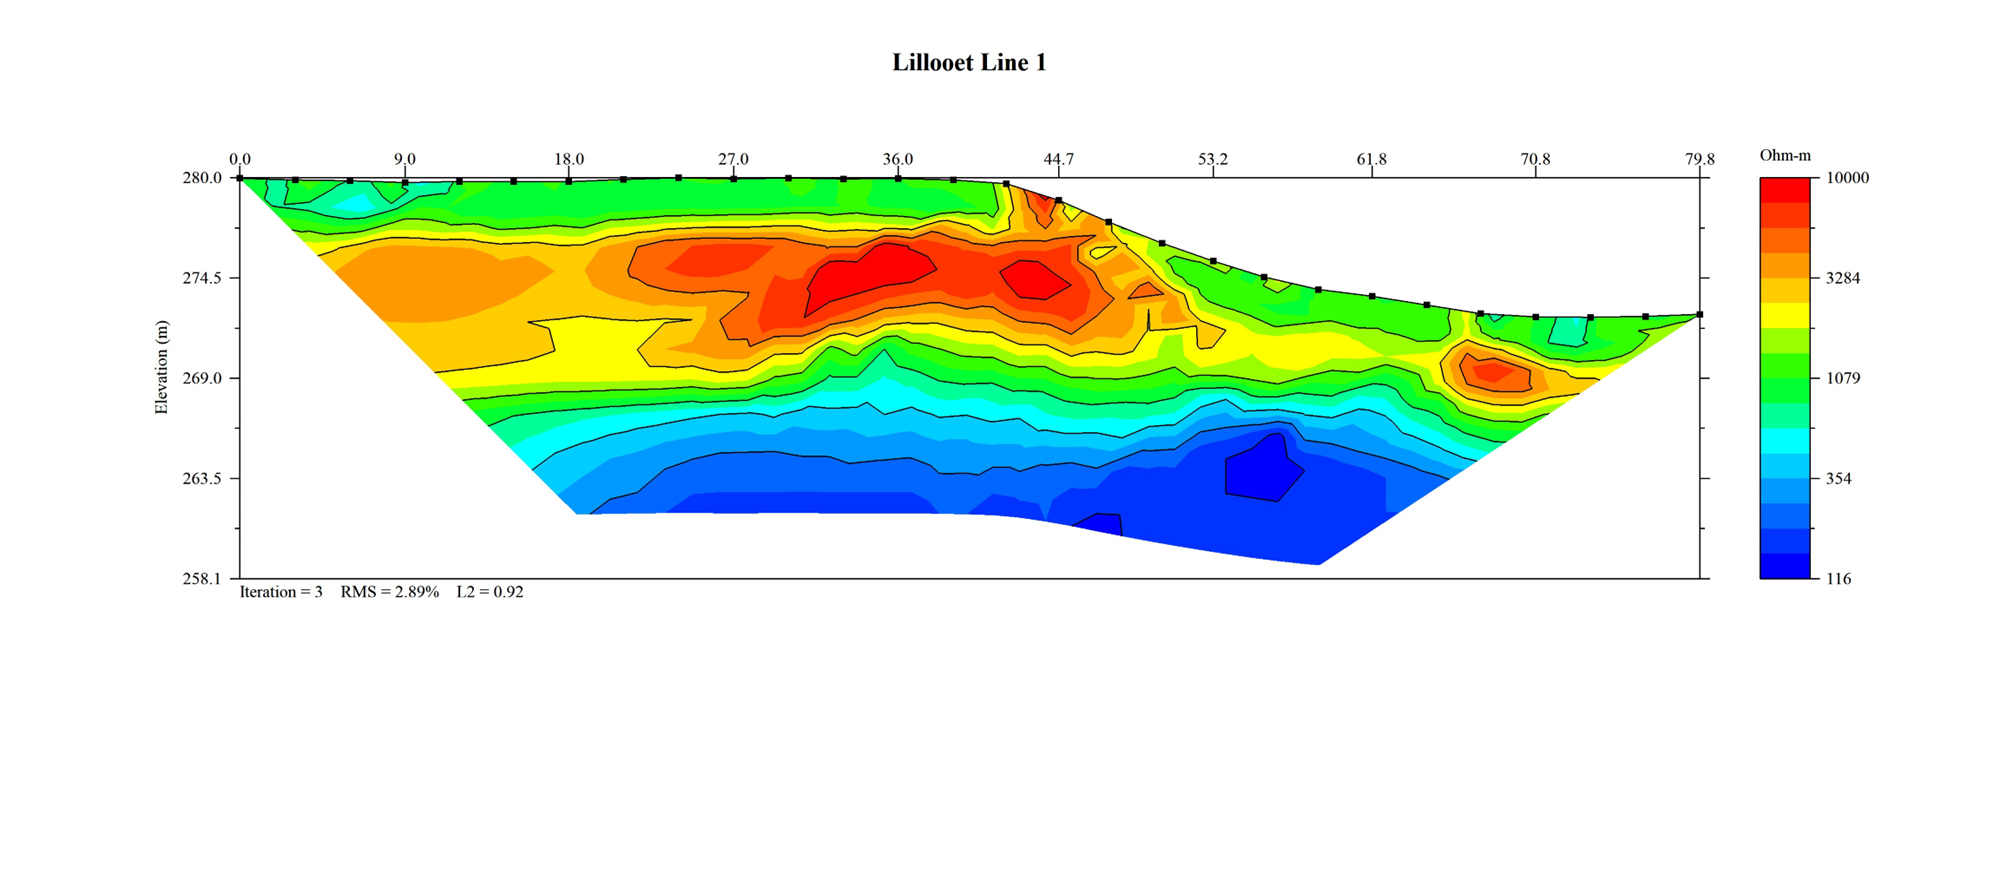

For now, this notebook loosely follows the SimPEG 2.5D DC Resistivity tutorial notebook (https://simpeg.xyz/user-tutorials/fwd-dcr-2d). 

## Import packages for forward modelling

In [ ]:
# SimPEG functionality
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.utils import model_builder
from simpeg.utils.io_utils.io_utils_electromagnetics import write_dcip2d_ubc
from simpeg import maps, data
from simpeg.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
    generate_survey_from_abmn_locations
)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz

# Common Python functionality
import os
import numpy as np
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

mpl.rcParams.update({"font.size": 14})  # default font size

write_output = False  # Optional

## Define topography 
...as a numpy.ndarray. 
This comes from field data.

Lillooet Line 1 (3 meter spacing), SW to NE.

In [ ]:
# Define column names
topography_file_column_names = ['x','z']

# Use pandas to read .trn file
topography_2d = pd.read_table('./fieldData/Terrain_Line1_3m_Aug26_2024.trn',
                        names=topography_file_column_names, skiprows=3, delimiter=',', skipinitialspace=True)

# See if it was read correctly
topography_2d

In [ ]:
# Plot 2D topography
fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(topography_2d.iloc[:,0], topography_2d.iloc[:,1], color="b", linewidth=2)
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("z (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=10)
plt.show(fig)

In [ ]:
# Create figure
fig1, ax1 = plt.subplots(1,1, figsize = (12,3))
# Plot z-column vs x-column
ax1.plot(topography_2d.iloc[:,0], topography_2d.iloc[:,1], color="b", linewidth=2)
# Set vertical exaggeration to 1
ax1.set_aspect('equal', adjustable='box')
# Extend ylimit down by a fraction of full x-width, and buffer up by 5 m
fraction = 1/4
depth = (topography_2d['x'].max() - topography_2d['x'].min()) * fraction
ax1.set_ylim(topography_2d['z'].min()-depth,topography_2d['z'].max()+5)
# Other plot elements
ax1.grid()
ax1.set_xlabel('x [m]')
ax1.set_ylabel('Elevation [m]')
ax1.set_title('Topography (VE=1)', fontsize=16, pad=10)
plt.show()

## Create locations_a_indices, locations_b_indices, locations_m_indices, locations_n_indices
...from raw AGI MiniSting .stg raw data files, given the electrode spacing.

First extract dipole-dipole data from file: $a$ (dipole size), $na$ (distance between dipoles), $x_{mp}$ (x-coordinate for the midpoint between the two dipoles)



In [ ]:
# Indicate column names
raw_data_column_names = [
    'datum', 'type', 'date', 'time', 'V/I', 'error in per mille', 'current [mA]', 'apparent resistivity [Ohm-m]', 'a', 'na', 'x_mp'
]

# Use pandas to read .stg file
raw_data = pd.read_table('./fieldData/3m_Texas_Creek_line1_2024.stg', sep=',', header=0, names = raw_data_column_names,
                         skiprows=3, skipfooter=1, skipinitialspace=True, engine='python',
                         usecols=[0,1,2,3,4,5,6,7,8,9,10])

# Check to see if the data was imported correctly
# raw_data

In [ ]:
# Remove rows with type != DIP-DIP
raw_data = raw_data[raw_data.loc[:,'type'].str.contains("DIP-DIP", na=False)]

# Check to see if this worked
raw_data

In [ ]:
# Set datatypes of a, na, and x_mp to float so that we can do math on them
raw_data.loc[:,'a'] = raw_data.loc[:,'a'].astype(float)
raw_data.loc[:,'na'] = raw_data.loc[:,'na'].astype(float)
raw_data.loc[:,'x_mp'] = raw_data.loc[:,'x_mp'].astype(float)

# Check
raw_data

Given electrode spacing $s$,

$$i = \frac{x_{mp}}{s} - \frac{\frac{na}{s}}{2}$$

$$j = i - \frac{a}{s}$$

$$k = \frac{x_{mp}}{s} + \frac{\frac{na}{s}}{2}$$

$$l = k + \frac{a}{s}$$

where $i$ is the A index, $j$ is the B index, $k$ is the M index, and $l$ is the N index.

In [ ]:
# Set the electrode spacing, s:
s = 3.0

# Calculate the indices and set their data types to integers
locations_a_indices = (raw_data.loc[:,'x_mp'] / s) - (raw_data.loc[:,'na'] / s)/2
locations_a_indices = locations_a_indices.astype(int)

locations_b_indices = locations_a_indices - (raw_data.loc[:,'a']/s)
locations_b_indices = locations_b_indices.astype(int)

locations_m_indices = (raw_data.loc[:,'x_mp']/ s) + (raw_data.loc[:,'na'] / s) / 2
locations_m_indices = locations_m_indices.astype(int)

locations_n_indices = locations_m_indices + (raw_data.loc[:,'a'] / s)
locations_n_indices = locations_n_indices.astype(int)

In [ ]:
# Also extract the field-measured apparent resistivities
field_apparent_resistivities = raw_data.loc[:,'apparent resistivity [Ohm-m]']

# Find the size of the data, n, based on the number of field-measured apparent resistivities
n = len(field_apparent_resistivities)

# Initialize locations arrays, with dimensions n by 2 (n for the number of data points, 2 for x and z)
locations_a = np.zeros((n,2))
locations_b = np.zeros((n,2))
locations_m = np.zeros((n,2))
locations_n = np.zeros((n,2))

## Extract x and z locations using indices

In [ ]:
# Extract the x and z values from the topography_2d dataframe, using the indices from the .stg file
for i in range(n):
    locations_a[i] = [topography_2d.loc[np.array(locations_a_indices)[i],'x'], topography_2d.loc[np.array(locations_a_indices)[i],'z']]
    locations_b[i] = [topography_2d.loc[np.array(locations_b_indices)[i],'x'], topography_2d.loc[np.array(locations_b_indices)[i],'z']]
    locations_m[i] = [topography_2d.loc[np.array(locations_m_indices)[i],'x'], topography_2d.loc[np.array(locations_m_indices)[i],'z']]
    locations_n[i] = [topography_2d.loc[np.array(locations_n_indices)[i],'x'], topography_2d.loc[np.array(locations_n_indices)[i],'z']]

## Generate survey and plot

In [ ]:
# Finally, generate the survey from the locations calculated above.
survey = generate_survey_from_abmn_locations(locations_a=locations_a, locations_b=locations_b,
                                             locations_m=locations_m, locations_n=locations_n,
                                             data_type='apparent_resistivity')
survey

In [ ]:
# Extract pseudo-locations from survey object
pseudo_locations_xz = pseudo_locations(survey)

# Overprint figure 1 with the electrodes and pseudo-locations
fig1, ax1 = plt.subplots(1,1, figsize = (12,4))

# Plot topography z-column vs x-column
ax1.plot(topography_2d.iloc[:,0], topography_2d.iloc[:,1], color="b", linewidth=2, label='surface', zorder=1)
# Plot electrodes B and N. They are the outer electrodes, so we plot them to show the full range of electrodes.
ax1.scatter(locations_b[:,0], locations_b[:,1], 8, "r", label='electrodes')
ax1.scatter(locations_n[:,0], locations_n[:,1], 8, "r")
# Plot pseudo-locations
ax1.scatter(pseudo_locations_xz[:, 0], pseudo_locations_xz[:, -1], 8, "b", label='pseudo-locations')
# Set vertical exaggeration to 1
ax1.set_aspect('equal', adjustable='box')

# Other plot elements
ax1.grid()
ax1.legend()
ax1.set_xlabel('x [m]')
ax1.set_ylabel('Pseudo-elevation [m]')
ax1.set_title('Pseudo-locations (VE=1)', fontsize=16, pad=10)
plt.show()

## Design a tree mesh

In [ ]:
dh = 0.6 # minimum cell width
dz = dh # minimum cell height

# Domain width
dom_width_x = topography_2d.iloc[:,0].max()-topography_2d.iloc[:,0].min()
# Domain height, with a buffer based on percentage of depth to deepest pseudo-location
height_buffer_percentage = 10
dom_height_z = (topography_2d.iloc[:,1].max()-pseudo_locations_xz[:,1].min()) * (1+(height_buffer_percentage/100))

# number of base cells in x and z
nbcx = 2 ** (int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))+1)
nbcz = 2 ** (int(np.ceil(np.log(dom_height_z / dz) / np.log(2.0))))

# Define the base mesh with top at z = 0 m.
hx = [(dh, nbcx)]
hz = [(dz, nbcz)]
mesh = TreeMesh([hx, hz], x0="0N", diagonal_balance=True)

# Shift top to maximum topography
mesh.origin = mesh.origin + np.r_[0.0, np.max(topography_2d.iloc[:,1])]

# Mesh refinement based on topography
mesh.refine_surface(
    topography_2d,
    padding_cells_by_level=[10,10,5,5],
    finalize=False,
)

# Extract unique electrode locations.
unique_locations = survey.unique_electrode_locations

# Mesh refinement near electrodes.
# mesh.refine_points(
#     unique_locations, padding_cells_by_level=[1, 1, 1, 1], finalize=False
# )

mesh.finalize()

print("# of cells: {}".format(mesh.n_cells))  # Number of cells
print("# of x-faces: {}".format(mesh.n_faces_x))  # Number of x-faces
print("Origin: {}".format(mesh.origin))  # bottom-southewest corner
print("Max cell volume: {}".format(mesh.cell_volumes.max()))  # Largest cell size
print(mesh.cell_centers[0:5, :])  # Cell center locations

### Plot the mesh

In [ ]:
fig2, ax2 = plt.subplots(1,1, figsize=(8,4))

# Plot mesh
mesh.plot_grid(ax=ax2, linewidth = 1, zorder=1)

# Overlay topography, electrodes, and pseudo-locations
# Plot topography z-column vs x-column
ax2.plot(topography_2d.iloc[:,0], topography_2d.iloc[:,1], color="b", linewidth=2, label='surface', zorder=1)
# Plot electrodes B and N. They are the outer electrodes, so we plot them to show the full range of electrodes.
ax2.scatter(locations_b[:,0], locations_b[:,1], 8, "r", label='electrodes')
ax2.scatter(locations_n[:,0], locations_n[:,1], 8, "r")
# Plot pseudo-locations
ax2.scatter(pseudo_locations_xz[:, 0], pseudo_locations_xz[:, -1], 8, "b", label='pseudo-locations')
# Set vertical exaggeration to 1
ax2.set_aspect('equal', adjustable='box')

# Set x and y limits
buffer_in_meters = 5
xlim_max = topography_2d.iloc[:,0].max()
xlim_min = topography_2d.iloc[:,0].min()
ylim_max = topography_2d.iloc[:,1].max()
ylim_min = pseudo_locations_xz[:,1].min()
ax2.set_xlim(xlim_min-buffer_in_meters, xlim_max+buffer_in_meters)
ax2.set_ylim(ylim_min-buffer_in_meters, ylim_max+buffer_in_meters)

# Other plot elements
ax2.grid(False)
ax2.set_ylabel('z [m]')
ax2.set_xlabel('x [m]')
ax2.set_title('Tree Mesh')

plt.show()

### Define the active cells

In [ ]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
topo = topography_2d.to_numpy()
active_cells = active_from_xyz(mesh, topo)

# number of active cells
n_active = np.sum(active_cells)

## Build a hypothetical "true" model

In [ ]:
# Define resistivity values of different materials
air_resistivity = 1e+8
mud_resistivity = 1e+2
sand_resistivity = 1e+3
gravel_resistivity = 1e+4

In [ ]:
# Define background resistivity model
resistivity_model = sand_resistivity *np.ones(n_active)

# Add units of different resistivities
ind_gravel = model_builder.get_indices_block(np.r_[0,269],np.r_[48,276],mesh.cell_centers[active_cells, :])
resistivity_model[ind_gravel] = gravel_resistivity

ind_gravel2 = model_builder.get_indices_block(np.r_[65,267],np.r_[80,271],mesh.cell_centers[active_cells, :])
resistivity_model[ind_gravel2] = gravel_resistivity

ind_mud = model_builder.get_indices_block(np.r_[0,255],np.r_[80,266],mesh.cell_centers[active_cells,:])
resistivity_model[ind_mud] = mud_resistivity

In [ ]:
# Resistivity map. Model parameters are resistivities for all active cells.
# Assign value of air to inactive cells
resistivity_map = maps.InjectActiveCells(mesh=mesh, active_cells=active_cells, value_inactive=air_resistivity)

# Generate a mapping to ignore inactive cells in plot. Whenever you want to plot the model, you need to multiply
# the resistivity values by this plotting map
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

In [ ]:
fig3, ax3 = plt.subplots(1,1, figsize=(9,4))

colormap_name = 'jet'

# Map log of minimum and maximum resistivities to the colormap 0 to 1 range.
norm = LogNorm(vmin=mud_resistivity, vmax=gravel_resistivity)

# Plot resistivity values on mesh
mesh.plot_image(
    plotting_map * resistivity_model,
    ax=ax3,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": colormap_name}
)

# Overlay mesh, topography, electrodes, and pseudo-locations
# Plot mesh
mesh.plot_grid(ax=ax3, linewidth = 0.5, alpha=0.5, color='black')
# Plot topography z-column vs x-column
ax3.plot(topography_2d.iloc[:,0], topography_2d.iloc[:,1], color="b", linewidth=2, label='surface', zorder=1)
# Plot electrodes B and N. They are the outer electrodes, so we plot them to show the full range of electrodes.
ax3.scatter(locations_b[:,0], locations_b[:,1], 8, "r", label='electrodes')
ax3.scatter(locations_n[:,0], locations_n[:,1], 8, "r")
# Plot pseudo-locations
ax3.scatter(pseudo_locations_xz[:, 0], pseudo_locations_xz[:, -1], 8, "b", label='pseudo-locations')
# Set vertical exaggeration to 1
ax3.set_aspect('equal', adjustable='box')

# Configure x- and y-axes
ax3.set_xlim(xlim_min-buffer_in_meters, xlim_max+buffer_in_meters)
ax3.set_ylim(ylim_min-buffer_in_meters, ylim_max+buffer_in_meters)
ax3.set_title("Resistivity Model")
ax3.set_xlabel("x (m)")
ax3.set_ylabel("z (m)")
ax3.grid(False)

# Add colorbar
scalarMappable = plt.cm.ScalarMappable(cmap=colormap_name, norm=norm)
scalarMappable.set_array([])
cbar = fig3.colorbar(scalarMappable, ax=ax3)
cbar.set_label(r"resistivity ($\Omega \cdot m$)", rotation=270, labelpad=15, size=12)

plt.show()

### Project electrodes to discretized topography

In [ ]:
survey.drape_electrodes_on_topography(mesh, active_cells, option="top")

## Define the forward simulation

In [ ]:
# First define the DC simulation given the survey setup, the mesh, and the active parts of the mesh
simulation_res = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, rhoMap=resistivity_map
)

## Predict the DC resistivity data from the model

In [ ]:
survey.set_geometric_factor(space_type='half-space')

# Simulate the data from the model
dpred_res = simulation_res.dpred(resistivity_model)
# The dpred is in measured normalized voltages (voltage divided by current, volts/amps, V/A; i.e., resistance).

# Check the size of dpred_res
dpred_res.size

## Plot data in pseudosection

In [ ]:
# Get apparent resistivities from volts and survey geometry
apparent_resistivities = apparent_resistivity_from_voltage(survey,dpred_res)

In [ ]:
fig4, ax4 = plt.subplots(2,1, figsize=(8,8))

# TOP PLOT
plot_pseudosection(
    data=survey,
    dobs=np.abs(dpred_res),
    plot_type="scatter",
    ax=ax4[0],
    scale="log",
    cbar_label="Resistance [V/A]",
    scatter_opts={"cmap": colormap_name}
)

# Overlay topography, electrodes, and pseudo-locations
ax4[0].grid()
# Plot topography z-column vs x-column
ax4[0].plot(topography_2d.iloc[:,0], topography_2d.iloc[:,1], color="b", linewidth=2, label='surface', zorder=1)
# Plot electrodes B and N. They are the outer electrodes, so we plot them to show the full range of electrodes.
ax4[0].scatter(locations_b[:,0], locations_b[:,1], 8, "r", label='electrodes')
ax4[0].scatter(locations_n[:,0], locations_n[:,1], 8, "r")
# Set vertical exaggeration to 1
ax4[0].set_aspect('equal', adjustable='box')

# Configure x- and y-axes
ax4[0].set_xlim(xlim_min-buffer_in_meters, xlim_max+buffer_in_meters)
ax4[0].set_ylim(ylim_min-buffer_in_meters, ylim_max+buffer_in_meters)
ax4[0].set_xlabel("")
ax4[0].set_ylabel("Pseudo-elevation [m]")
ax4[0].set_title("Normalized Voltages")

# BOTTOM PLOT
plot_pseudosection(
    survey,
    dobs= apparent_resistivities,
    plot_type="contourf",
    ax=ax4[1],
    scale="log",
    cbar_label=r"$\Omega \cdot m$",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": colormap_name},
)
ax4[1].set_title("Apparent Resistivity")
# Overlay topography, electrodes, and pseudo-locations
ax4[1].grid()
# Plot topography z-column vs x-column
ax4[1].plot(topography_2d.iloc[:,0], topography_2d.iloc[:,1], color="b", linewidth=2, label='surface', zorder=1)
# Plot electrodes B and N. They are the outer electrodes, so we plot them to show the full range of electrodes.
ax4[1].scatter(locations_b[:,0], locations_b[:,1], 8, "r", label='electrodes')
ax4[1].scatter(locations_n[:,0], locations_n[:,1], 8, "r")
# Set vertical exaggeration to 1
ax4[1].set_aspect('equal', adjustable='box')
# Plot pseudo-locations
ax4[1].scatter(pseudo_locations_xz[:, 0], pseudo_locations_xz[:, -1], marker=".", s=4, color='grey', label='pseudo-locations')

# Configure x- and y-axes
ax4[1].set_xlim(xlim_min-buffer_in_meters, xlim_max+buffer_in_meters)
ax4[1].set_ylim(ylim_min-buffer_in_meters, ylim_max+buffer_in_meters)
ax4[1].set_xlabel("x [m]")
ax4[1].set_ylabel("Pseudo-elevation [m]")

fig4.tight_layout()

## Export output

In [ ]:
# if write_output:
#     dir_path = os.path.sep.join([".", "fwd_dcr_2d_outputs"]) + os.path.sep
#     if not os.path.exists(dir_path):
#         os.mkdir(dir_path)

#     # Add 5% Gaussian noise to each datum
#     rng = np.random.default_rng(seed=225)
#     std = 0.05 * np.abs(dpred_con)
#     dc_noise = rng.normal(scale=std, size=len(dpred_con))
#     dobs = dpred_con + dc_noise

#     # Create a survey with the original electrode locations
#     # and not the shifted ones
#     # Generate source list for DC survey line
#     source_list = generate_dcip_sources_line(
#         survey_type,
#         data_type,
#         dimension_type,
#         end_locations,
#         topo_2d,
#         num_rx_per_src,
#         station_separation,
#     )
#     survey_original = dc.survey.Survey(source_list)

#     # Write out data at their original electrode locations (not shifted)
#     data_obj = data.Data(survey_original, dobs=dobs, standard_deviation=std)
#     fname = dir_path + "dc_data.obs"
#     write_dcip2d_ubc(fname, data_obj, "volt", "dobs")

#     fname = dir_path + "topo_2d.txt"
#     np.savetxt(fname, topo_2d, fmt="%.4e")

## Create Data object

In [ ]:
# Add 5% Gaussian noise to each datum for the simulated data
# Create random number generator (RNG)
rng = np.random.default_rng(seed=225)
std = 0.05 * np.abs(dpred_res)
dc_noise = rng.normal(scale=std, size=len(dpred_res))
dobs = dpred_res + dc_noise

# Create data object
data_dc = data.Data(survey, dobs=dobs, standard_deviation=std)

In [ ]:
# For field data
# Assume uncertainties are 10% of the data value
field_standard_deviation = 0.1 * np.abs(field_apparent_resistivities)
field_dobs = np.log(field_apparent_resistivities)
field_data_dc = data.Data(survey, dobs=field_dobs, standard_deviation=field_standard_deviation)

# DC Resisitvity 2.5D least-squares inversion 

## Import packages

In [ ]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tarfile

from discretize import TreeMesh
from discretize.utils import mkvc, active_from_xyz

from simpeg.utils import model_builder
from simpeg import (
    maps,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
)
from simpeg.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc


mpl.rcParams.update({"font.size": 16})
# sphinx_gallery_thumbnail_number = 4

## Load data, define survey, and plot

In [ ]:
# dobs=apparent_resistivities

In [ ]:
# standard_deviation = 0.05 * np.abs

In [ ]:
# simulation_res

## Starting/Reference Model and Mapping on Tree Mesh

Here, we would create starting and/or reference models for the DC inversion as
well as the mapping from the model space to the active cells. Starting and
reference models can be a constant background value or contain a-priori
structures. Here, the starting model is the natural log of 0.01 S/m.

In [ ]:
active_cells

In [ ]:
# Define conductivity model in S/m (or resistivity model in Ohm m)

background_resistivity = sand_resistivity

# active_map = maps.InjectActiveCells(mesh, ind_active, np.exp(air_conductivity))
nC = int(active_cells.sum())

# conductivity_map = active_map * maps.ExpMap()

# Define model
# starting_conductivity_model = sand_resistivity * np.ones(nC)

In [ ]:
# Define model
starting_resistivity_model = background_resistivity * np.ones(nC)

## Define the Physics of the DC Simulation

Here, we define the physics of the DC resistivity problem.

In [ ]:
simulation_res

## Define the DC Inverse Problem
The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem

In [ ]:
field_data_dc

In [ ]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(data=field_data_dc, simulation=simulation_res)

# Define the regularization (model objective function)
reg = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_cells,
    reference_model=starting_resistivity_model,
)

reg.reference_model_in_smooth = True  # Reference model in smoothness term

# Define how the optimization problem is solved. Here we will use an
# Inexact Gauss Newton approach.
opt = optimization.InexactGaussNewton(maxIter=40)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

## Define DC Inversion Directives

Here we define any directives that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.

In [ ]:
# Apply and update sensitivity weighting as the model updates
update_sensitivity_weighting = directives.UpdateSensitivityWeights()

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=3, coolingRate=2)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Update preconditioner
update_jacobi = directives.UpdatePreconditioner()

directives_list = [
    update_sensitivity_weighting,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
    update_jacobi,
]

## Running the DC Inversion

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.

In [ ]:
# Here we combine the inverse problem and the set of directives
dc_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
recovered_resistivity_model = dc_inversion.run(starting_resistivity_model)

In [ ]:
recovered_resistivity_model

## Plot

In [ ]:
referencemodel = resistivity_model
norm = LogNorm(vmin=1e+0, vmax=1e+4)
fig5, ax5 = plt.subplots(2,1, figsize=(9,9))

# TOP PLOT
mesh.plot_image(
    plotting_map * referencemodel,
    ax=ax5[0],
    grid=False,
    pcolor_opts={"norm": norm, "cmap": colormap_name},
)
# Overlay mesh, topography, electrodes, and pseudo-locations
# Plot mesh
mesh.plot_grid(ax=ax5[0], linewidth = 0.5, alpha=0.5, color='black')
ax5[0].grid(False)
# Plot topography z-column vs x-column
ax5[0].plot(topography_2d.iloc[:,0], topography_2d.iloc[:,1], color="b", linewidth=2, label='surface', zorder=1)
# Plot electrodes B and N. They are the outer electrodes, so we plot them to show the full range of electrodes.
ax5[0].scatter(locations_b[:,0], locations_b[:,1], 8, "r", label='electrodes')
ax5[0].scatter(locations_n[:,0], locations_n[:,1], 8, "r")
# Set vertical exaggeration to 1
ax5[0].set_aspect('equal', adjustable='box')

# Configure x- and y-axes
ax5[0].set_xlim(xlim_min-buffer_in_meters, xlim_max+buffer_in_meters)
ax5[0].set_ylim(ylim_min-buffer_in_meters, ylim_max+buffer_in_meters)
ax5[0].set_xlabel("")
ax5[0].set_ylabel("z [m]")
ax5[0].set_title("True Resistivity Model")

# Add colorbar
scalarMappable = plt.cm.ScalarMappable(cmap=colormap_name, norm=norm)
scalarMappable.set_array([])
cbar_top = fig5.colorbar(scalarMappable, ax=ax5[0])
cbar_top.set_label(r"resistivity ($\Omega \cdot m$)", rotation=270, labelpad=15, size=12)

# BOTTOM PLOT
mesh.plot_image(
    plotting_map * recovered_resistivity_model,
    ax=ax5[1],
    grid=False,
    pcolor_opts={"norm": norm, "cmap": colormap_name},
)
# Overlay mesh, topography, electrodes, and pseudo-locations
# Plot mesh
mesh.plot_grid(ax=ax5[1], linewidth = 0.5, alpha=0.5, color='black')
ax5[1].grid(False)
# Plot topography z-column vs x-column
ax5[1].plot(topography_2d.iloc[:,0], topography_2d.iloc[:,1], color="b", linewidth=2, label='surface', zorder=1)
# Plot electrodes B and N. They are the outer electrodes, so we plot them to show the full range of electrodes.
ax5[1].scatter(locations_b[:,0], locations_b[:,1], 8, "r", label='electrodes')
ax5[1].scatter(locations_n[:,0], locations_n[:,1], 8, "r")
# Set vertical exaggeration to 1
ax5[1].set_aspect('equal', adjustable='box')

# Configure x- and y-axes
ax5[1].set_xlim(xlim_min-buffer_in_meters, xlim_max+buffer_in_meters)
ax5[1].set_ylim(ylim_min-buffer_in_meters, ylim_max+buffer_in_meters)
ax5[1].set_xlabel("x [m]")
ax5[1].set_ylabel("z [m]")
ax5[1].set_title("Recovered Resistivity Model")

# Add colorbar
cbar_bottom = fig5.colorbar(scalarMappable, ax=ax5[1])
cbar_bottom.set_label(r"resistivity ($\Omega \cdot m$)", rotation=270, labelpad=15, size=12)

## Results 1: Using data simulated from hypothetical true model
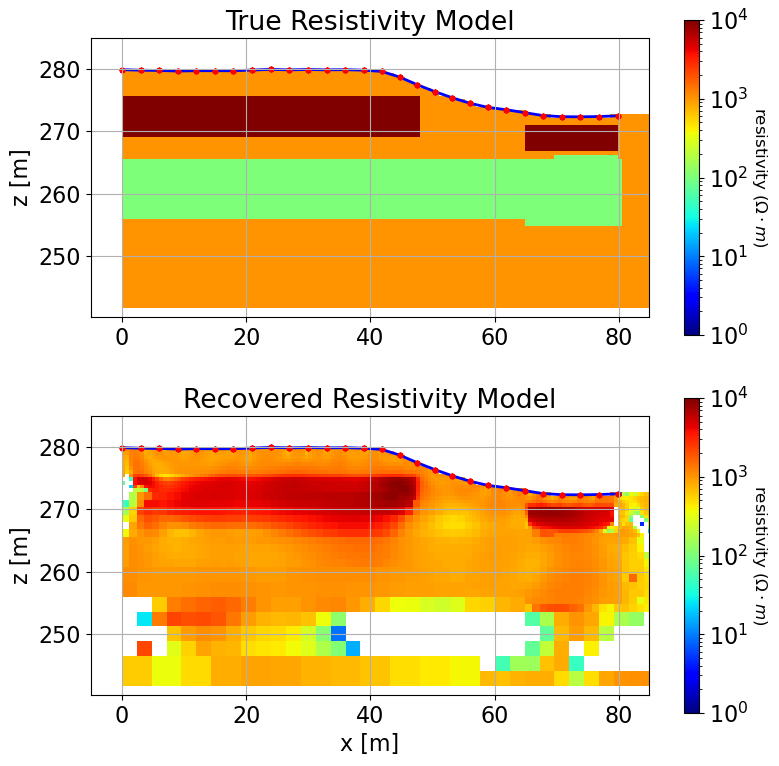 

## Results 2: Starting model: sand, reference model = hypothetical true model, data inverted = field data
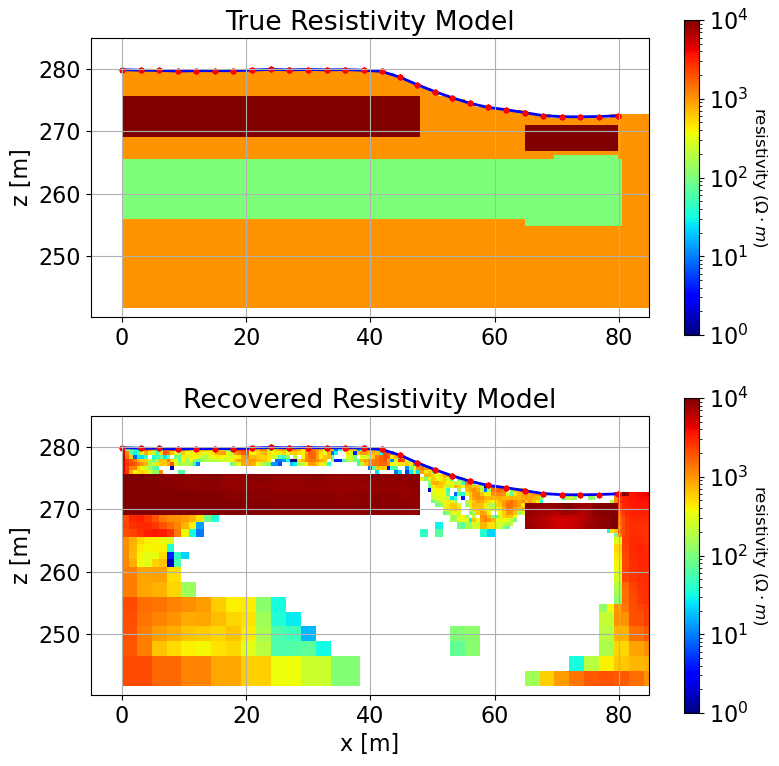

## Results 3: Starting model: all sand, reference model: all sand, inverted data: field data
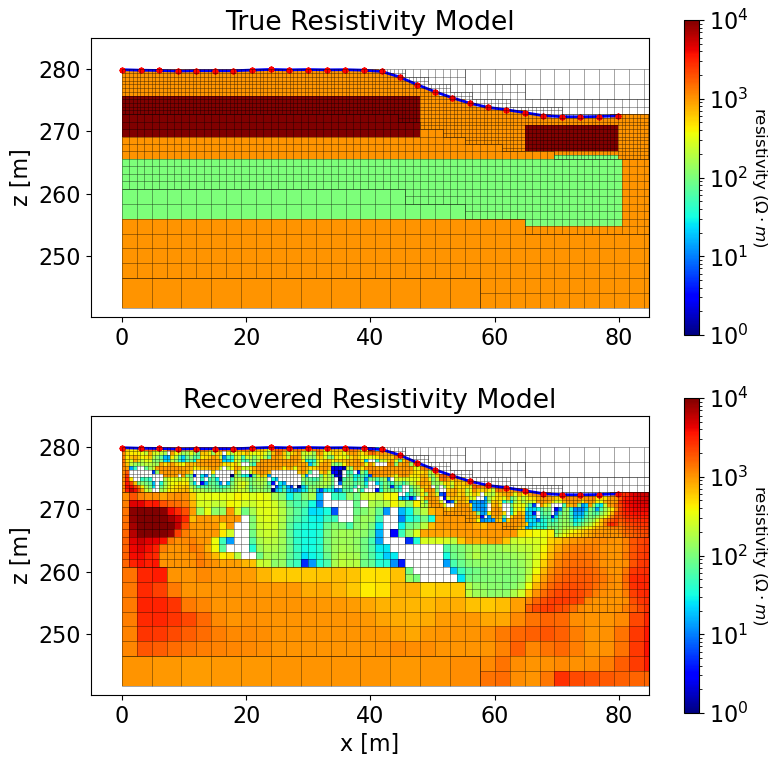